# Data Importing

In [1]:
import psycopg2
import pandas as pd
import json

In [2]:
def call_df(table_name):
    with open('config.json', 'r') as f:
        config = json.load(f)
        
    conn = psycopg2.connect(user = config['USER'],
                              password = config['PASSWORD'],
                              host = config['HOST'],
                              port = config['PORT'],
                              database = config['DATABASE'])
    
    sql = f'SELECT * FROM {table_name}'
    df = pd.read_sql_query(sql, conn)
    conn.close()
    return df

In [3]:
district = call_df('crawling_db.district_table')
apartment = call_df('crawling_db.apartment_table').drop(columns='table_id')
school = call_df('crawling_db.school_table').drop(columns='table_id')
price = call_df('crawling_db.price_table')
subway = call_df('crawling_db.subway_table').drop(columns='table_id')

In [4]:
df = (price.merge(apartment, how='left', on='apartment_id').
      merge(district, how='left', on='district_id').
      merge(school, how='left', on='apartment_id').
      merge(subway, how='left', on='apartment_id'))

# EDA

## 라이브러리

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.font_manager as fm

path = 'C:/Windows/Fonts/malgun.ttf'
font_name = fm.FontProperties(fname=path, size=50).get_name()
plt.rc('font', family=font_name)

%matplotlib inline

---
## 아파트 ID
### 아파트 ID의 개수
- 아파트 ID는 몇 개인가? 즉, 몇 종류의 아파트가 있을까?

In [6]:
n_apt = len(df['apartment_id'].unique())
print(f'서울특별시에는 {n_apt} 종류의 아파트(ID)가 있다.')

서울특별시에는 5683 종류의 아파트(ID)가 있다.


### 아파트 ID별 거래량
- 그동안 아파트 ID별 몇 건의 거래가 있었을까?

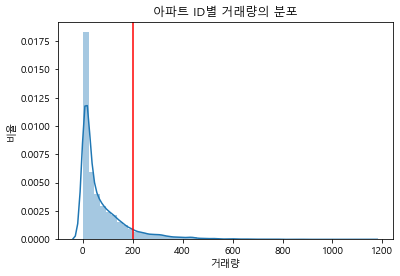

총 거래량이 200번 이하인 아파트 ID가 전체에서 89%의 비율을 차지


In [7]:
apt_count = df['apartment_id'].value_counts().to_frame('count') # 아파트 ID별 거래량(count) 
graph_1 = sns.distplot(apt_count) # 그래프
graph_1.axvline(200, color='red') # 수직선
plt.title('아파트 ID별 거래량의 분포')
plt.xlabel('거래량'); plt.ylabel('비율')
plt.show()
print(f"총 거래량이 200번 이하인 아파트 ID가 전체에서 {round(len(apt_count[apt_count['count']<=200])/n_apt*100)}%의 비율을 차지")

### 아파트 ID별 거래월별 분포
- 아파트 매매 거래는 주거의 목적을 내포하고 있기 때문에 거래일자의 분포가 촘촘하지 않을 수 있다. 실제로 그런지 확인하기 위해 EDA를 실행한다.

#### 총 거래월 수
- 자료의 최소 시간 단위는 '월(month)'로 구성되어 있다.

In [8]:
n_period = len(df['period'].unique())
print(f"{df['period'].min()}부터 {df['period'].max()}까지 총 {n_period}의 개월로 분포한다.")

2006.01부터 2020.04까지 총 172의 개월로 분포한다.


#### 거래 없는 달의 분포
- 아파트 ID별로 거래가 아예 없는 월이 있을 것으로 생각된다. 이를 확인해보도록 한다.

In [9]:
apt_per = (df[['apartment_id','period']].drop_duplicates(). # 아파트 ID별로 몇 개의 기간이 있는가
           groupby('apartment_id')['period'].count().to_frame('count').reset_index() # 있는 기간은 총 몇 개인가
          )
apt_per['count'] = 172 - apt_per['count'] # 총 개월 수에서 빼주면 결측값

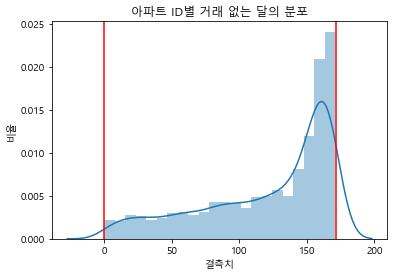

In [10]:
graph_2 = sns.distplot(apt_per['count']) # 그래프
graph_2.axvline(0, color='red') # 최소
graph_2.axvline(172, color='red') # 최대
plt.title('아파트 ID별 거래 없는 달의 분포')
plt.xlabel('결측치'); plt.ylabel('비율')
plt.show()

- 아파트 ID별로 거래가 아예 없는 달이 매우 많습니다. 따라서 사용자가 어떤 아파트 매매가의 예측값을 알고 싶더라도, 샘플이 거의 없어 예측이 불가능할 수 있습니다. 따라서 저희는 클러스터링 기법을 통해 샘플의 수를 인위적으로 늘리고자 합니다.